# Finding and Visualizing Time Series Motifs of Varying Lengths with the Pan Matrix Profile

This tutorial utilizes the main takeaways from the [Matrix Profile XX](https://www.cs.ucr.edu/~eamonn/PAN_SKIMP%20%28Matrix%20Profile%20XX%29.pdf) research paper.

In the [STUMPY basics](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html) tutorial, we learned how to compute matrix profiles and motifs from any time series data given a user-defined window size. However, the proper choice of this window size may require trial-and-error or domain knowledge and, most importantly, it is possible that a single time series may contain multiple motifs with different window sizes. 

Here, we'll introduce a new function called `stumpy.stimp` that provdes a quick way to compute a "Pan Matrix Profile" (i.e., a set of approximate matrix profiles with different window sizes), which then gives you an informed way to visualize and pick the best window sizes for motif discovery. 

## Getting Started

Let’s import the packages that we’ll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML
import os
import stumpy

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

## Loading the Eye Blinking Dataset

This data contains a 100 second excerpt of an electro-oculogram (EOG) eye movement dataset (recorded at a rate of 100 times/second) where we are interested in identifying regions corresponding to the "blinking of the eye" as a human subject begins dozing off and falling asleep (see Figure 1 in [Matrix Profile XX](https://www.cs.ucr.edu/~eamonn/PAN_SKIMP%20%28Matrix%20Profile%20XX%29.pdf)): 

In [2]:
eog_df = pd.read_csv("https://zenodo.org/record/4733142/files/eog.csv?download=1")
eog_df.head()

,EOG
0,-349.666667
1,-291.000000
2,-1112.333333
3,-1550.000000
4,-1827.333333


# Visualizing the EOG Dataset

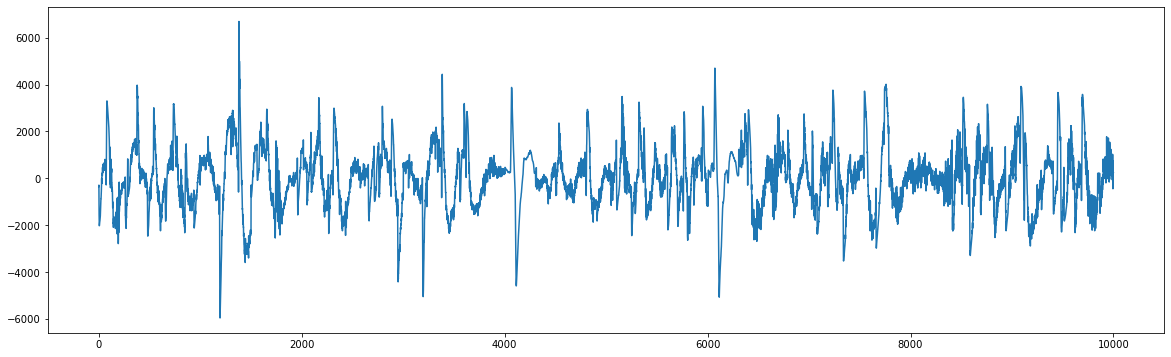

In [3]:
plt.plot(eog_df["EOG"].values)
plt.show()

# Discovering Motifs with Domain Knowledge

Given that a "sleepy blink" is a ubiquitous human action, some studies suggest that using a 1.5 to 2.5 seconds window size (i.e., `m = 250`) may be a suitable duration of time for identifying eye blinks. And, indeed, we can use `stumpy.stump` to discover this motif:

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


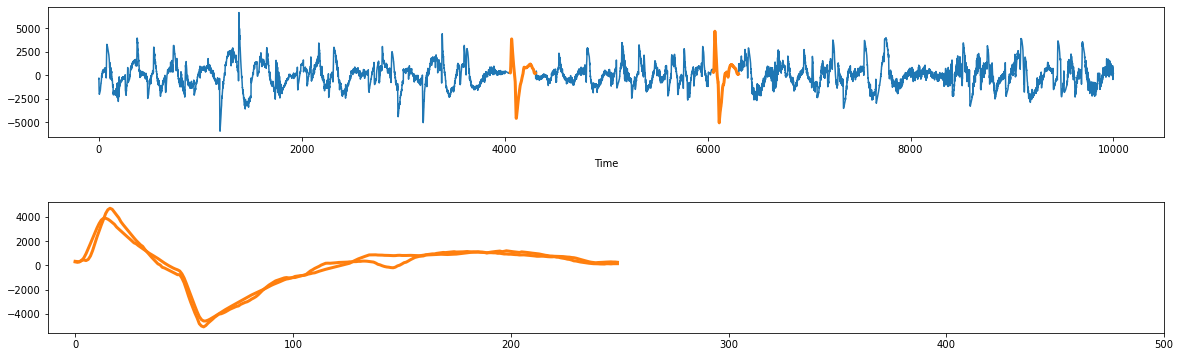

In [4]:
m_250 = 250
mp_250 = stumpy.stump(eog_df["EOG"], m=m_250)
motif_idx_250 = np.argmin(mp_250[:, 0])
nn_idx_250 = mp_250[motif_idx_250, 1]

fig, axs = plt.subplots(2)
fig.subplots_adjust(hspace=.5)
axs[0].plot(eog_df["EOG"].values)
axs[0].plot(np.arange(motif_idx_250, motif_idx_250 + m_250), eog_df.iloc[motif_idx_250 : motif_idx_250 + m_250], lw=3, color='C1')
axs[0].plot(np.arange(nn_idx_250, nn_idx_250 + m_250), eog_df.iloc[nn_idx_250 : nn_idx_250 + m_250], lw=3, color='C1')
axs[1].plot(np.arange(m_250), eog_df.iloc[motif_idx_250 : motif_idx_250 + m_250], lw=3, color='C1')
axs[1].plot(np.arange(m_250), eog_df.iloc[nn_idx_250 : nn_idx_250 + m_250], lw=3, color='C1')
axs[0].set_xlabel("Time")
xlimx, _ = axs[1].get_xlim()
axs[1].set_xlim(xlimx, 500)
plt.show()

However, these longer-than-normal eye blinks are actually unique to the individual and its detection is also sensitve to the placement of the sensor. Therefore, a one-size-fits-all window size may not be the appropriate for discovering all motifs in this data and you may need to test a wider range of windows sizes in order to be exhaustive. Indeed, hidden within this time series is a second type of eye blink artifact with a window size of approximately 5 seconds (i.e., `m = 500`) that may have been missed by even the most observant sleep technician. Can you spot where this other motif is? Let's find it!

In [5]:
m_500 = 500
mp_500 = stumpy.stump(eog_df["EOG"], m=m_500)
motif_idx_500 = np.argmin(mp_500[:, 0])
nn_idx_500 = mp_500[motif_idx_500, 1]

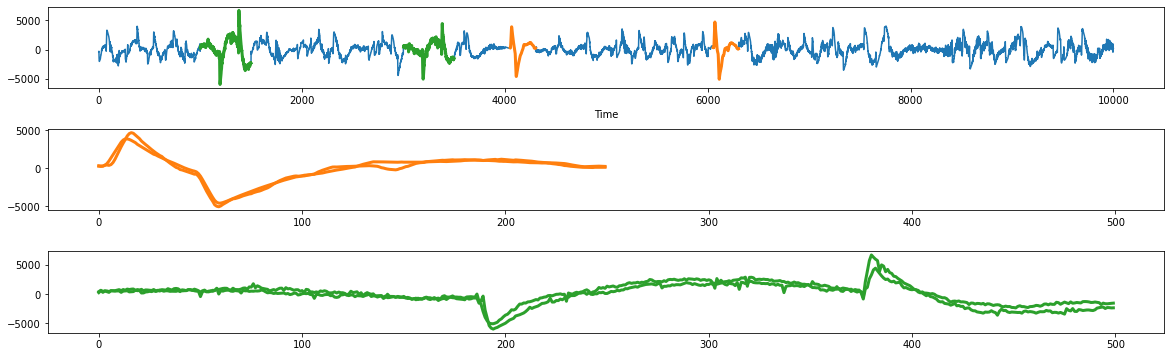

In [6]:
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=.5)

axs[0].plot(eog_df["EOG"].values)
axs[0].plot(np.arange(motif_idx_250, motif_idx_250 + m_250), eog_df.iloc[motif_idx_250 : motif_idx_250 + m_250], lw=3, color='C1')
axs[0].plot(np.arange(nn_idx_250, nn_idx_250 + m_250), eog_df.iloc[nn_idx_250 : nn_idx_250 + m_250], lw=3, color='C1')
axs[0].plot(np.arange(motif_idx_500, motif_idx_500 + m_500), eog_df.iloc[motif_idx_500 : motif_idx_500 + m_500], lw=3, color='C2')
axs[0].plot(np.arange(nn_idx_500, nn_idx_500 + m_500), eog_df.iloc[nn_idx_500 : nn_idx_500 + m_500], lw=3, color='C2')
axs[1].plot(np.arange(m_250), eog_df.iloc[motif_idx_250 : motif_idx_250 + m_250], lw=3, color='C1')
axs[1].plot(np.arange(m_250), eog_df.iloc[nn_idx_250 : nn_idx_250 + m_250], lw=3, color='C1')
axs[2].plot(np.arange(m_500), eog_df.iloc[motif_idx_500 : motif_idx_500 + m_500], lw=3, color='C2')
axs[2].plot(np.arange(m_500), eog_df.iloc[nn_idx_500 : nn_idx_500 + m_500], lw=3, color='C2')
axs[1].set_xlim(axs[2].get_xlim())
axs[0].set_xlabel("Time")
plt.show()

The first thing that you might have noticed is that the 2.5 second-long blink (orange) and the 5 second-long blink (green) have some subtle similarities but, overall, there are other characteristics that distinguish them from each other. Of course, the real question is, without any domain knowledge or additional help, would you have been able to pick out the two different window sizes (i.e., `m = 250` and `m = 500`) needed to extract these motifs?

Furthermore, beyond these two motifs, can you spot whether or not there are other shorter/longer motifs in this time series? As a naive strategy, you may be tempted to compute matrix profiles across a range of window sizes from, say, `m = 100` up to `m = 1000` and then systematically review every motif along the way in order to find the "best" window size(s). However, this can be rather time consuming if there is only one motif-producing window size near the higher end of your range (i.e., you'll spend most of your time scanning irrelevant window sizes) or, at times, it may be wasteful since window sizes surrounding/neighboring a motif-producing window size often produce similar/redundant matrix profiles. Thus, we need a more efficient to compute approximate matrix profiles incrementally that cover a user-defined range of window sizes. This is where `stumpy.stimp` comes in! 

## Compute the Pan Matrix Profile using STIMP

Essentially, `stumpy.stimp` implements [Table 2](https://www.cs.ucr.edu/~eamonn/PAN_SKIMP%20%28Matrix%20Profile%20XX%29.pdf). 

In [7]:
min_m, max_m = 100, 1000
eog = stumpy.stimp(eog_df["EOG"].values, min_m=min_m, max_m=max_m, percentage=0.01)  # This percentage controls the extent of `stumpy.scrump` completion
percent_m = 0.01  # The percentage of windows to compute
n = np.ceil((max_m - min_m) * percent_m).astype(int)
for _ in range(n):
    eog.update()

Above, we select a range of window sizes from `min_m = 3` to `max_m = 1000` and we arrange the windows in this range according to a breadth first order (this is done automatically by `stumpy.stimp` and you can read more about it in [slide 32](https://drive.google.com/file/d/1eT9oHOAKoi4oGkUX26V9aZIopov0Pxt5/view) and/or in [Section C in Matrix Profile XX](https://www.cs.ucr.edu/~eamonn/PAN_SKIMP%20%28Matrix%20Profile%20XX%29.pdf)). The order of the window sizes to be processed can be found in `.M_` attribute:

In [8]:
eog.M_[:n]

array([550, 325, 776, 212, 438, 663, 889, 156, 269])

Notice that we don't compute the matrix profiles (approximated using `stumpy.scrump` at 1% and with `pre-scrump` turned on) for all of the window sizes and, instead, we select only 1% of the window sizes (`percent_m = 0.01`) for this task. So, only a total of `n` matrix profiles were computed. Now, let's plot our pan matrix profile along with the locations of our motif pairs (vertical red lines):

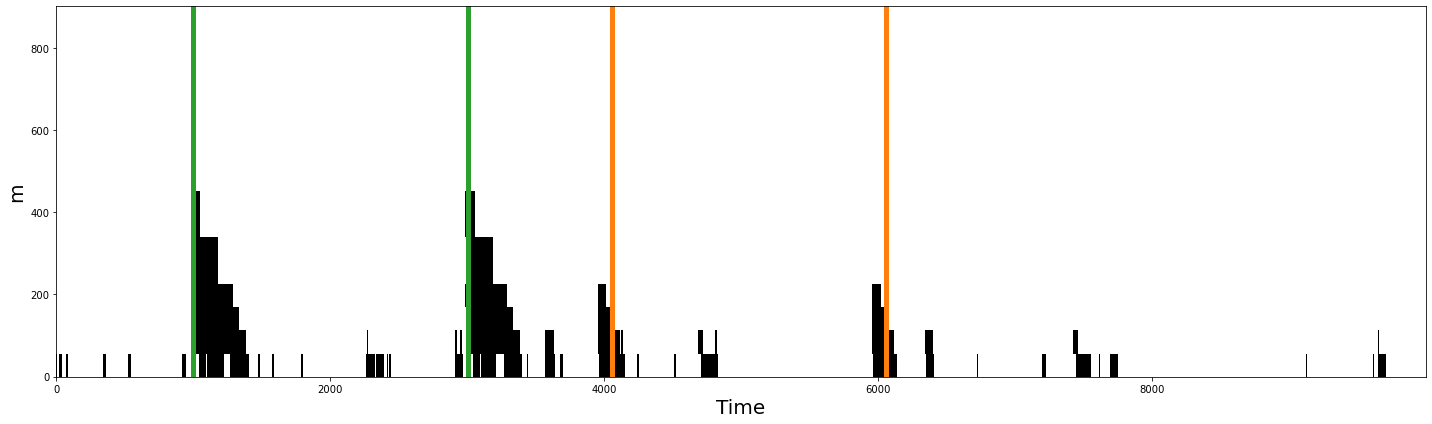

In [10]:
fig = plt.figure()
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

color_map = cm.get_cmap("Greys_r", 256)
im = plt.imshow(eog.PAN_, cmap=color_map, origin="lower", interpolation="none", aspect="auto")
plt.xlabel("Time", fontsize="20")
plt.ylabel("m", fontsize="20")
plt.clim(0.0, 1.0)
plt.tight_layout()

# Draw some vertical lines where each motif and nearest neighbor are located
plt.axvline(motif_idx_250, lw=5, color='C1')
plt.axvline(nn_idx_250, lw=5, color='C1')
plt.axvline(motif_idx_500, lw=5, color='C2')
plt.axvline(nn_idx_500, lw=5, color='C2')

plt.show()

Now, we'll compute 2% more matrix profiles (for a total of 1% + 2% = 3%) for additional windows:

In [11]:
for _ in range(2 * n):
    eog.update()

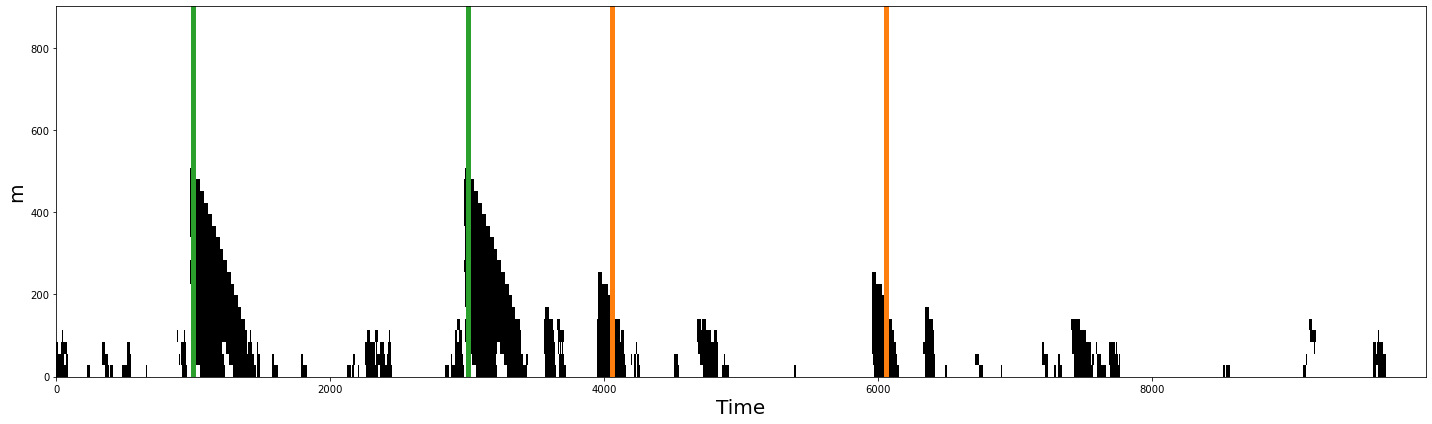

In [12]:
fig = plt.figure()
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

color_map = cm.get_cmap("Greys_r", 256)
im = plt.imshow(eog.PAN_, cmap=color_map, origin="lower", interpolation="none", aspect="auto")
plt.xlabel("Time", fontsize="20")
plt.ylabel("m", fontsize="20")
plt.clim(0.0, 1.0)
plt.tight_layout()

# Draw some vertical lines where each motif and nearest neighbor are located
plt.axvline(motif_idx_250, lw=5, color='C1')
plt.axvline(nn_idx_250, lw=5, color='C1')
plt.axvline(motif_idx_500, lw=5, color='C2')
plt.axvline(nn_idx_500, lw=5, color='C2')

plt.show()

Notice how the pan matrix profile has become a bit clearer and a less "blocky"?

## Steamgen Example

In [13]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
m = 640
mp = stumpy.stump(steam_df["steam flow"], m=m)
motif_idx = np.argmin(mp[:, 0])
nn_idx = mp[motif_idx, 1]

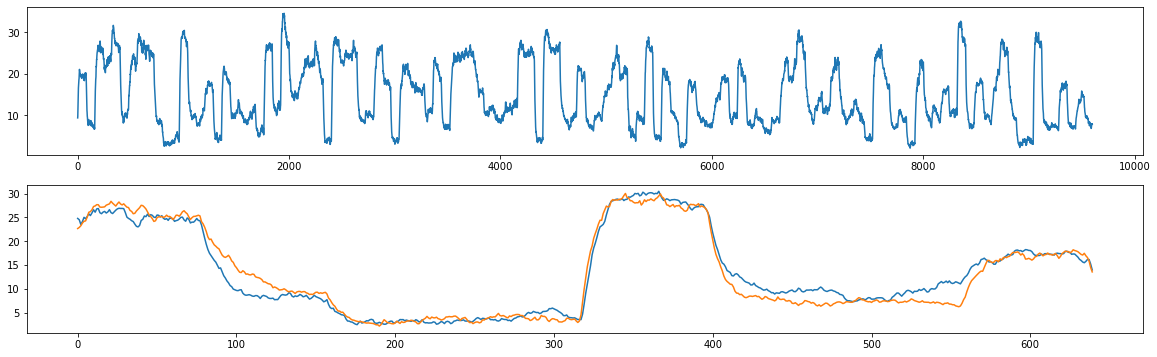

In [14]:
fig, axs = plt.subplots(2)
axs[0].plot(steam_df["steam flow"].values)
axs[1].plot(np.arange(m), steam_df["steam flow"].iloc[motif_idx : motif_idx + m])
axs[1].plot(np.arange(m), steam_df["steam flow"].iloc[nn_idx : nn_idx + m])
plt.show()

### Compute the Pan Matrix Profile using STIMP

In [15]:
min_m, max_m = 100, 3000
steam = stumpy.stimp(steam_df['steam flow'], min_m=min_m, max_m=max_m, percentage=0.01)  # This percentage controls the extent of `stumpy.scrump` completion
percent_m = 0.01  # The percentage of windows to compute
n = np.ceil((max_m - min_m) * percent_m).astype(int)
for _ in range(n):
    steam.update()

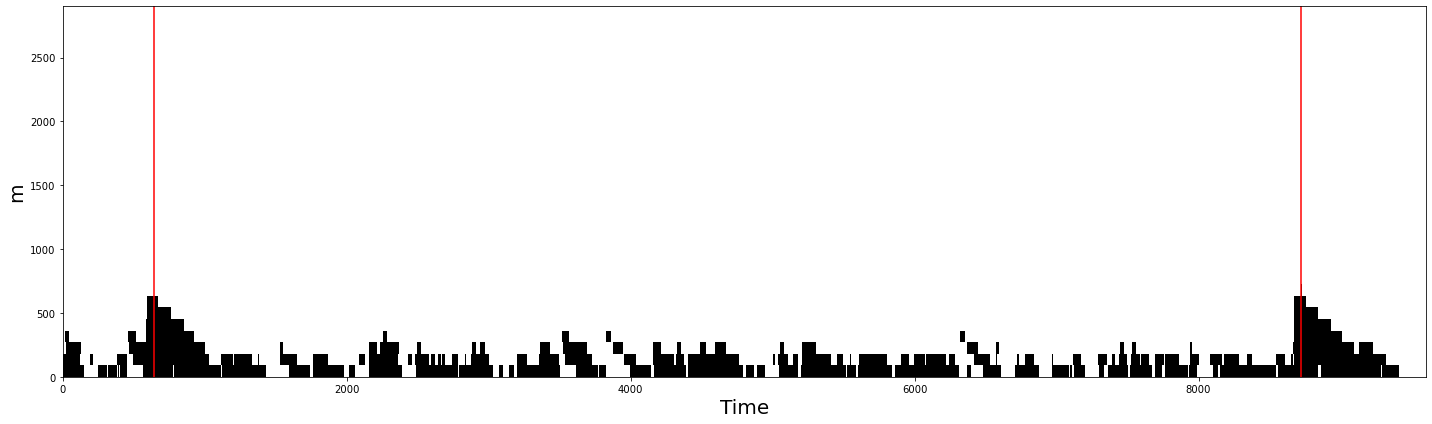

In [16]:
fig = plt.figure()
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

lines = [motif_idx, nn_idx]
color_map = cm.get_cmap("Greys_r", 256)
im = plt.imshow(steam.PAN_, cmap=color_map, origin="lower", interpolation="none", aspect="auto")
plt.xlabel("Time", fontsize="20")
plt.ylabel("m", fontsize="20")
plt.clim(0.0, 1.0)
plt.tight_layout()

if lines is not None:
    for line in lines:
        plt.axvline(x=line, color='red')

plt.show()

In [17]:
for _ in range(2 * n):
    steam.update()

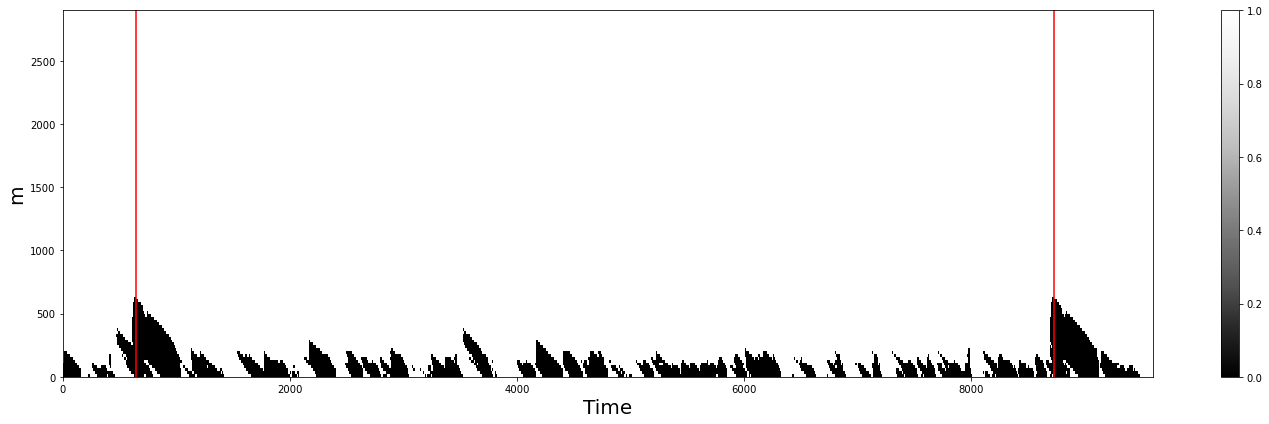

In [18]:
fig = plt.figure()
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

lines = [motif_idx, nn_idx]
color_map = cm.get_cmap("Greys_r", 256)
im = plt.imshow(steam.PAN_, cmap=color_map, origin="lower", interpolation="none", aspect="auto")
plt.xlabel("Time", fontsize="20")
plt.ylabel("m", fontsize="20")
plt.colorbar()
plt.tight_layout()

for line in lines:
    plt.axvline(x=line, color='red')

plt.show()

## Bonus Section

In [19]:
pan_thresholds = []
n = 100
for i in range(0, n):
    threshold = i/n
    PAN = steam.pan(threshold=threshold)
    pan_thresholds.append((threshold, PAN))

In [20]:
fig, axs = plt.subplots(1)

color_map = cm.get_cmap("Greys_r", 256)
img = axs.imshow(steam.PAN_, cmap=color_map, origin="lower", interpolation="none", aspect="auto")
axs.set_xlabel("Time", fontsize="20")
axs.set_ylabel("m", fontsize="20")
img.set_clim(0.0, 1.0)
plt.tight_layout()
fontdict = {
    'fontsize': '24'
}
txt = plt.text(750, 2500, "", fontdict=fontdict)

for line in lines:
    plt.axvline(x=line, color='red')

def init():
    img.set_data(np.ones(img.get_size()))
    return [img]

def animate(pan_threshold):
    threshold, pan = pan_threshold
    if threshold > 0.6:
        txt.set_position((750, 250))
        txt.set_color("white")
    if threshold == 0.2:
        default = "(default)"
    else:
        default = ""
    txt.set_text(f"threshold = {np.round(threshold, 2)} {default}")
    img.set_data(pan)
    return [img]

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init,
                               frames=pan_thresholds, interval=100,
                               blit=True)

anim_out = anim.to_jshtml()
anim_out = anim_out.replace("this.current_frame = 0;", f"this.current_frame = {int(0.2 * n)};")  # Set/change starting frame
plt.close()  # Prevents duplicate image from displaying
if os.path.exists("None0000000.png"):
    os.remove("None0000000.png")  # Delete rogue temp file

HTML(anim_out)